<a href="https://colab.research.google.com/github/gokul-pv/EVA6_Assignmets_Session7/blob/main/EVA6_Session_7_CIFAR10_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

In [3]:
!pip install -U git+https://github.com/albu/albumentations

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-rtuyew7h
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-rtuyew7h
  Created wheel for albumentations: filename=albumentations-1.0.0-cp37-none-any.whl size=98151 sha256=d7146f9ff00ed41be42e311907471cb18d34d5572e3ab64ffb80078499257bba
  Stored in directory: /tmp/pip-ephem-wheel-cache-x6mh887i/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 1.0.0
    Uninstalling albumentations-1.0.0:
      Successfully uninstalled albumentations-1.0.0


In [4]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [5]:
import sys
folder = '/content/gdrive/MyDrive/Colab'
sys.path.append(folder)

In [6]:
import albumentations as A
import albumentations.pytorch as AP
import random

In [7]:
class AlbumentationTransforms:

  """
  Helper class to create test and train transforms using Albumentations
  """

  def __init__(self, transforms_list=[]):
    transforms_list.append(AP.ToTensorV2())
    self.transforms = A.Compose(transforms_list)


  def __call__(self, img):
    img = np.array(img)
    #print(img)
    return self.transforms(image=img)['image']

**Viewing the applies transformations**

In [8]:
channel_means = (0.4919, 0.4827, 0.4472)
channel_stdevs = (0.2470, 0.2434, 0.2616)


expample_transform = AlbumentationTransforms([
                                       A.HorizontalFlip(),
                                       A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
                                       A.CoarseDropout(max_holes = 1, max_height=16, max_width=16,  min_holes = 1, min_height=16, min_width=16, 
                                                       fill_value=channel_means, mask_fill_value = None),
                                       A.Normalize(mean=channel_means, std=channel_stdevs),
                                       
                                       ])

In [9]:
import copy
import random

MEAN = torch.tensor([0.485, 0.456, 0.406])
STD = torch.tensor([0.229, 0.224, 0.225])


def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = expample_transform
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        # image = image / 2 + 0.5     # unnormalize
        image = image * STD[:, None, None] + MEAN[:, None, None]
        # plt.imshow(x.numpy().transpose(1, 2, 0))
        ax.ravel()[i].imshow(np.transpose(image, (1, 2, 0)))
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

Files already downloaded and verified


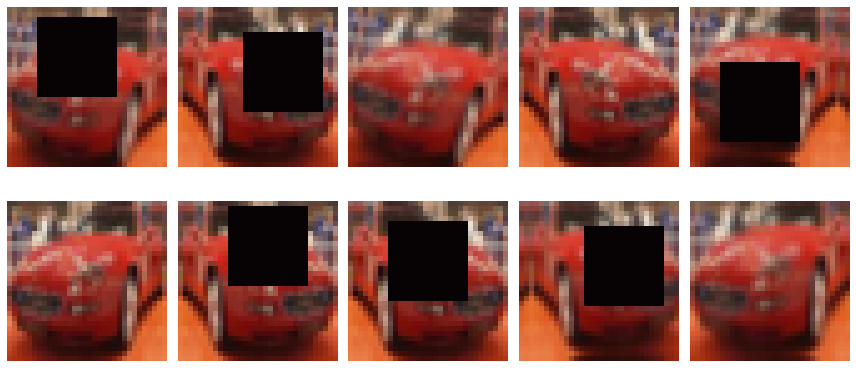

In [10]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True)
random.seed(42)
visualize_augmentations(trainset,5)

In [11]:
channel_means = (0.4919, 0.4827, 0.4472)
channel_stdevs = (0.2470, 0.2434, 0.2616)

train_transforms = AlbumentationTransforms([
                                       A.HorizontalFlip(),
                                       A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
                                       A.CoarseDropout(max_holes = 1, max_height=16, max_width=16,  min_holes = 1, min_height=16, min_width=16, 
                                                       fill_value=channel_means, mask_fill_value = None),
                                       A.Normalize(mean=channel_means, std=channel_stdevs),
                                       
                                       ])
# Test Phase transformations
test_transforms = AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])

In [12]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [13]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)


trainloader = torch.utils.data.DataLoader(trainset, **dataloader_args)
testloader = torch.utils.data.DataLoader(testset, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

In [14]:
data = np.concatenate((trainset.data, testset.data))


print('[Whole dataset ]')
print(' - Numpy Shape:', data.shape)
print(' - min:', np.min(data))
print(' - max:', np.max(data))
print(' - mean:', np.mean(data))
print(' - std:', np.std(data))
print(' - var:', np.var(data))

print('[Per Channel, standardised stats]')
print(' - mean:', np.round(data.mean(axis=(0,1,2))/255, 4))
print(' - std:', np.round(data.std(axis=(0,1,2))/255, 4))


[Whole dataset ]
 - Numpy Shape: (60000, 32, 32, 3)
 - min: 0
 - max: 255
 - mean: 120.84449672851562
 - std: 64.13596441053241
 - var: 4113.421930869079
[Per Channel, standardised stats]
 - mean: [0.4919 0.4827 0.4472]
 - std: [0.247  0.2434 0.2616]


In [15]:
trainset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

Let us show some of the training images, for fun.



Files already downloaded and verified
 ship  bird   cat   dog


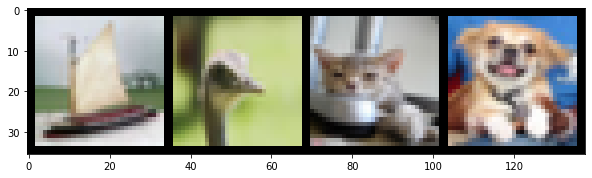

In [16]:
transform = transforms.Compose([
                                # transforms.RandomRotation((-7.0, 7.0), fill=(1,1,1)),
                                transforms.ToTensor()
                                # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])


trainset_ex = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader_ex = torch.utils.data.DataLoader(trainset_ex, batch_size=4,
                                          shuffle=True, num_workers=2)


# functions to show an image
def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader_ex)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolution Neural Network




In [25]:
import model

In [18]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = model.Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,864
             ReLU-10           [-1, 64, 32, 32]               0
      BatchNorm2d-11           [-1, 64, 32, 32]             128
          Dropout-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 16, 16]          36,864
           Conv2d-14           [-1

In [19]:
#Training & Testing Loops
from tqdm import tqdm

train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

def train(model, device, train_loader, optimizer, criterion, epoch):
  model.train()
  
  correct = 0
  processed = 0
  train_loss = 0

  pbar = tqdm(train_loader)
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)
    
    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)
    train_loss += loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_loss /= len(train_loader.dataset)    
  train_losses.append(train_loss)
  train_accuracy.append(100. * correct / len(train_loader.dataset)) 


    

In [20]:
def test(model, device, criterion, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()  

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracy.append(100. * correct / len(test_loader.dataset))

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    

3. Define a Loss function and optimizer. Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [21]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR , MultiStepLR

model = model.Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=12, gamma=0.1)

In [22]:
EPOCHS = 40

for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1, 'LR:',optimizer.param_groups[0]['lr'])
    train(model, device, trainloader, optimizer, criterion, epoch)
    # scheduler.step()
    test(model, device, criterion, testloader)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1 LR: 0.01


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=1.4727712869644165 Batch_id=390 Accuracy=38.26: 100%|██████████| 391/391 [00:19<00:00, 20.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0113, Accuracy: 4756/10000 (47.56%)

EPOCH: 2 LR: 0.01


Loss=1.3764817714691162 Batch_id=390 Accuracy=51.46: 100%|██████████| 391/391 [00:19<00:00, 20.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0090, Accuracy: 5881/10000 (58.81%)

EPOCH: 3 LR: 0.01


Loss=1.0788183212280273 Batch_id=390 Accuracy=57.45: 100%|██████████| 391/391 [00:19<00:00, 20.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0079, Accuracy: 6486/10000 (64.86%)

EPOCH: 4 LR: 0.01


Loss=0.8696190714836121 Batch_id=390 Accuracy=61.81: 100%|██████████| 391/391 [00:19<00:00, 20.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0067, Accuracy: 6959/10000 (69.59%)

EPOCH: 5 LR: 0.01


Loss=0.9973271489143372 Batch_id=390 Accuracy=65.00: 100%|██████████| 391/391 [00:19<00:00, 20.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0065, Accuracy: 7045/10000 (70.45%)

EPOCH: 6 LR: 0.01


Loss=1.0591901540756226 Batch_id=390 Accuracy=67.31: 100%|██████████| 391/391 [00:19<00:00, 20.31it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 7385/10000 (73.85%)

EPOCH: 7 LR: 0.01


Loss=0.8970058560371399 Batch_id=390 Accuracy=69.22: 100%|██████████| 391/391 [00:19<00:00, 20.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 7566/10000 (75.66%)

EPOCH: 8 LR: 0.01


Loss=0.4595392644405365 Batch_id=390 Accuracy=70.54: 100%|██████████| 391/391 [00:19<00:00, 20.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 7571/10000 (75.71%)

EPOCH: 9 LR: 0.01


Loss=1.1188665628433228 Batch_id=390 Accuracy=71.48: 100%|██████████| 391/391 [00:19<00:00, 20.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 7850/10000 (78.50%)

EPOCH: 10 LR: 0.01


Loss=0.7544733285903931 Batch_id=390 Accuracy=72.86: 100%|██████████| 391/391 [00:19<00:00, 20.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 7905/10000 (79.05%)

EPOCH: 11 LR: 0.01


Loss=0.9426683187484741 Batch_id=390 Accuracy=73.68: 100%|██████████| 391/391 [00:19<00:00, 20.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 7923/10000 (79.23%)

EPOCH: 12 LR: 0.01


Loss=0.8250740766525269 Batch_id=390 Accuracy=74.23: 100%|██████████| 391/391 [00:19<00:00, 20.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8030/10000 (80.30%)

EPOCH: 13 LR: 0.01


Loss=0.6931015849113464 Batch_id=390 Accuracy=74.51: 100%|██████████| 391/391 [00:19<00:00, 20.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8050/10000 (80.50%)

EPOCH: 14 LR: 0.01


Loss=0.6750600934028625 Batch_id=390 Accuracy=75.36: 100%|██████████| 391/391 [00:19<00:00, 20.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8099/10000 (80.99%)

EPOCH: 15 LR: 0.01


Loss=0.6707311272621155 Batch_id=390 Accuracy=75.73: 100%|██████████| 391/391 [00:19<00:00, 20.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8179/10000 (81.79%)

EPOCH: 16 LR: 0.01


Loss=0.6509031653404236 Batch_id=390 Accuracy=76.18: 100%|██████████| 391/391 [00:19<00:00, 19.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8181/10000 (81.81%)

EPOCH: 17 LR: 0.01


Loss=0.5909302830696106 Batch_id=390 Accuracy=76.62: 100%|██████████| 391/391 [00:19<00:00, 20.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8225/10000 (82.25%)

EPOCH: 18 LR: 0.01


Loss=0.5715233087539673 Batch_id=390 Accuracy=77.08: 100%|██████████| 391/391 [00:19<00:00, 20.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8232/10000 (82.32%)

EPOCH: 19 LR: 0.01


Loss=0.7294028997421265 Batch_id=390 Accuracy=77.35: 100%|██████████| 391/391 [00:19<00:00, 20.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8240/10000 (82.40%)

EPOCH: 20 LR: 0.01


Loss=0.6213346719741821 Batch_id=390 Accuracy=77.59: 100%|██████████| 391/391 [00:19<00:00, 20.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8238/10000 (82.38%)

EPOCH: 21 LR: 0.01


Loss=0.751609206199646 Batch_id=390 Accuracy=77.83: 100%|██████████| 391/391 [00:19<00:00, 20.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8345/10000 (83.45%)

EPOCH: 22 LR: 0.01


Loss=0.5340527892112732 Batch_id=390 Accuracy=78.15: 100%|██████████| 391/391 [00:19<00:00, 20.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8338/10000 (83.38%)

EPOCH: 23 LR: 0.01


Loss=0.7555422186851501 Batch_id=390 Accuracy=78.63: 100%|██████████| 391/391 [00:19<00:00, 20.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8422/10000 (84.22%)

EPOCH: 24 LR: 0.01


Loss=0.6098966002464294 Batch_id=390 Accuracy=78.96: 100%|██████████| 391/391 [00:19<00:00, 20.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8406/10000 (84.06%)

EPOCH: 25 LR: 0.01


Loss=0.5982983708381653 Batch_id=390 Accuracy=78.96: 100%|██████████| 391/391 [00:19<00:00, 20.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8397/10000 (83.97%)

EPOCH: 26 LR: 0.01


Loss=0.49593210220336914 Batch_id=390 Accuracy=79.15: 100%|██████████| 391/391 [00:19<00:00, 20.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8489/10000 (84.89%)

EPOCH: 27 LR: 0.01


Loss=0.6492916941642761 Batch_id=390 Accuracy=79.17: 100%|██████████| 391/391 [00:19<00:00, 19.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8398/10000 (83.98%)

EPOCH: 28 LR: 0.01


Loss=0.6569637060165405 Batch_id=390 Accuracy=79.80: 100%|██████████| 391/391 [00:19<00:00, 20.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8512/10000 (85.12%)

EPOCH: 29 LR: 0.01


Loss=0.9302269220352173 Batch_id=390 Accuracy=79.82: 100%|██████████| 391/391 [00:19<00:00, 20.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8525/10000 (85.25%)

EPOCH: 30 LR: 0.01


Loss=0.7400177717208862 Batch_id=390 Accuracy=79.93: 100%|██████████| 391/391 [00:19<00:00, 20.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8505/10000 (85.05%)

EPOCH: 31 LR: 0.01


Loss=0.6665648221969604 Batch_id=390 Accuracy=80.13: 100%|██████████| 391/391 [00:19<00:00, 20.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8518/10000 (85.18%)

EPOCH: 32 LR: 0.01


Loss=0.516119122505188 Batch_id=390 Accuracy=80.47: 100%|██████████| 391/391 [00:19<00:00, 20.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8564/10000 (85.64%)

EPOCH: 33 LR: 0.01


Loss=0.6816364526748657 Batch_id=390 Accuracy=80.50: 100%|██████████| 391/391 [00:19<00:00, 19.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8552/10000 (85.52%)

EPOCH: 34 LR: 0.01


Loss=0.43164199590682983 Batch_id=390 Accuracy=80.74: 100%|██████████| 391/391 [00:19<00:00, 20.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8568/10000 (85.68%)

EPOCH: 35 LR: 0.01


Loss=0.5255609750747681 Batch_id=390 Accuracy=80.84: 100%|██████████| 391/391 [00:19<00:00, 19.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8608/10000 (86.08%)

EPOCH: 36 LR: 0.01


Loss=0.5647810101509094 Batch_id=390 Accuracy=80.91: 100%|██████████| 391/391 [00:19<00:00, 19.66it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8543/10000 (85.43%)

EPOCH: 37 LR: 0.01


Loss=0.5982815623283386 Batch_id=390 Accuracy=81.50: 100%|██████████| 391/391 [00:19<00:00, 19.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8603/10000 (86.03%)

EPOCH: 38 LR: 0.01


Loss=0.5744844675064087 Batch_id=390 Accuracy=81.10: 100%|██████████| 391/391 [00:19<00:00, 19.65it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8545/10000 (85.45%)

EPOCH: 39 LR: 0.01


Loss=0.46863603591918945 Batch_id=390 Accuracy=81.26: 100%|██████████| 391/391 [00:19<00:00, 19.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8579/10000 (85.79%)

EPOCH: 40 LR: 0.01


Loss=0.7108942270278931 Batch_id=390 Accuracy=81.50: 100%|██████████| 391/391 [00:19<00:00, 20.03it/s]



Test set: Average loss: 0.0032, Accuracy: 8646/10000 (86.46%)



Plotting the misclassified image

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


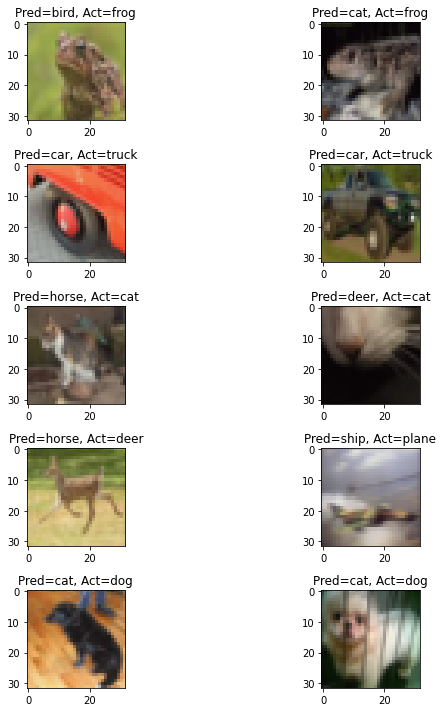

Accuracy for class plane is: 89.0 %
Accuracy for class car   is: 95.5 %
Accuracy for class bird  is: 80.5 %
Accuracy for class cat   is: 69.9 %
Accuracy for class deer  is: 81.4 %
Accuracy for class dog   is: 83.4 %
Accuracy for class frog  is: 88.8 %
Accuracy for class horse is: 90.8 %
Accuracy for class ship  is: 92.6 %
Accuracy for class truck is: 92.7 %


In [23]:
misclassified_images = []
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

MEAN = torch.tensor([0.485, 0.456, 0.406])
STD = torch.tensor([0.229, 0.224, 0.225])

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
        for i in range(len(predictions)):
            if predictions[i]!= labels[i]:
                misclassified_images.append([images[i], predictions[i], labels[i]])

fig = plt.figure(figsize = (10,10))
for i in range(10):
  sub = fig.add_subplot(5, 2, i+1)
  img = misclassified_images[i][0].cpu()
  img = img * STD[:, None, None] + MEAN[:, None, None]
  # img = img / 2 + 0.5 
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg,(1, 2, 0)),interpolation='none')
      
  sub.set_title("Pred={}, Act={}".format(str(classes[misclassified_images[i][1].data.cpu().numpy()]),
                                         str(classes[misclassified_images[i][2].data.cpu().numpy()])))
      
plt.tight_layout()
plt.show()

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,accuracy))


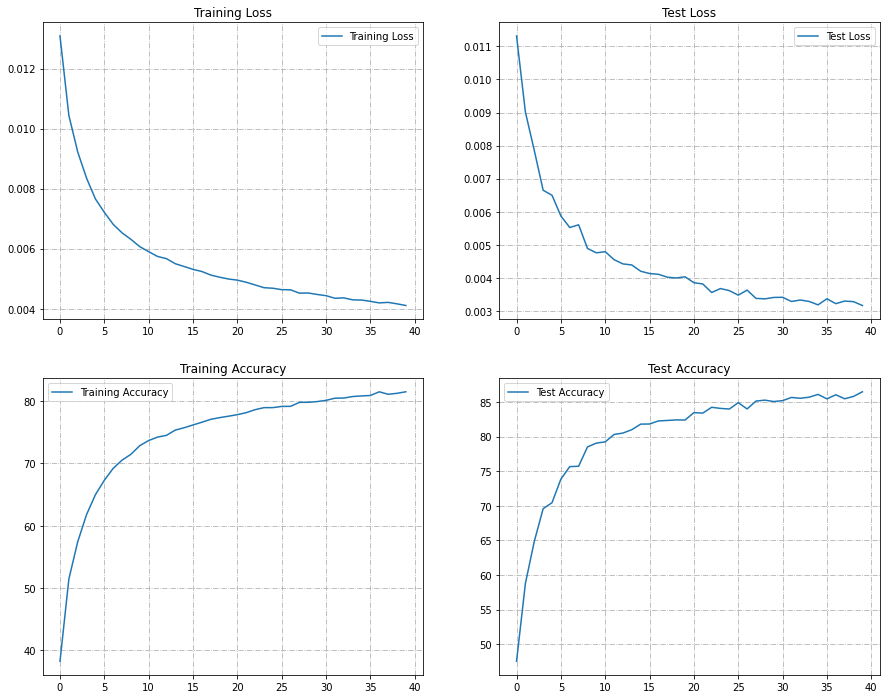

In [24]:

fig, axs = plt.subplots(2,2,figsize=(15,12))
axs[0, 0].plot(train_losses, label='Training Loss')
axs[0, 0].grid(linestyle='-.')
axs[0, 0].set_title("Training Loss")
axs[0, 0].legend()

axs[1, 0].plot(train_accuracy, label='Training Accuracy')
axs[1, 0].grid(linestyle='-.')
axs[1, 0].set_title("Training Accuracy")
axs[1, 0].legend()

axs[0, 1].plot(test_losses, label='Test Loss')
axs[0, 1].grid(linestyle='-.')
axs[0, 1].set_title("Test Loss")
axs[0, 1].legend()

axs[1, 1].plot(test_accuracy, label='Test Accuracy')
axs[1, 1].grid(linestyle='-.')
axs[1, 1].set_title("Test Accuracy")
axs[1, 1].legend()